<a href="https://colab.research.google.com/github/kgpark88/deeplearning/blob/master/energy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 라이브러리 임포트

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import auth
from google.colab import drive

## 데이터를 로드합니다. 

In [11]:
data_dir ='./'
file_name = 'energy_data.csv'
data_file = os.path.join(data_dir, file_name)
df = pd.read_csv(data_file, header = 0, delimiter = ',', quoting = 3)
df.index = df['daq_time']
series = df['power_usage'].values

### 데이터셋을 입력데이터와 타깃데이터로 분리하는 함수입니다.

In [12]:
def split_data_input_label(dataset, start_index, end_index, hist_data_size, target_size):
    data = []
    labels = []

    start_index = start_index + hist_data_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-hist_data_size, i)
        # Reshape data from (hist_data_size,) to (hist_data_size, 1)
        data.append(np.reshape(dataset[indices], (hist_data_size, 1)))
        labels.append([dataset[i+target_size]])
    return np.array(data), np.array(labels)

## 시계열 데이터값을 0과 1사이 값으로 정규화합니다.


In [13]:
train_split = 70080 # 365일 * 2년 * 96개데이터
test_split = 105120 # 365일 * 3년 * 96개데이터

min = np.min(series[:test_split])
max = np.max(series[:test_split])

dataset = (series - min)/max

## 훈련 데이터셋과 검증 데이터셋으로 데이터를 분할합니다.

In [14]:
n_steps = 20
future_target = 0

X_train, y_train = split_data_input_label(dataset, 0,train_split, 
                                          n_steps, 
                                          future_target)
X_valid, y_valid = split_data_input_label(dataset,train_split,test_split, 
                                          n_steps, 
                                          future_target)
X_test, _ = split_data_input_label(dataset, test_split, test_split+1000, 
                                   n_steps, 
                                   future_target)

In [15]:
X_train.shape

(70060, 20, 1)

## 입력데이터, 타깃데이터, 예측데이터를 그래프로 출력하는 함수입니다.

In [16]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$'):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bx', markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'ro')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

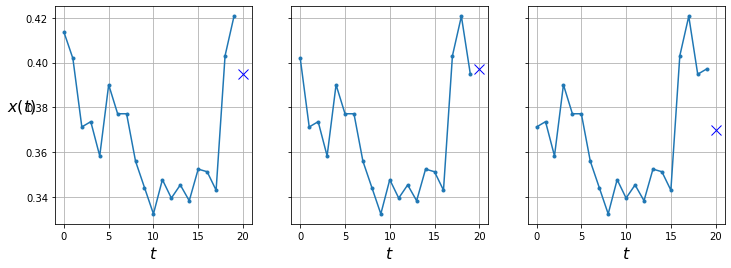

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=('$x(t)$' if col==0 else None))
plt.show()

## LSTM 모델 구성 

In [18]:
model = Sequential()

model.add(LSTM(20, input_shape=(None, 1), return_sequences=True))
model.add(LSTM(20))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

모델 구성 확인

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 20)          1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 5,481
Trainable params: 5,481
Non-trainable params: 0
_________________________________________________________________


초기 가중치 설정 확인

In [20]:
hidden1 = model.layers[0]
hidden1.get_weights()

[array([[ 0.1981529 , -0.17206539, -0.17838651, -0.11490017,  0.14646485,
         -0.2508344 , -0.23900956,  0.00631705,  0.18285507,  0.04944885,
         -0.24697381,  0.15715927, -0.229922  ,  0.06618476,  0.17561015,
          0.20302907,  0.07438976, -0.25508925,  0.10189161, -0.22858457,
          0.26951283,  0.16680261, -0.0694973 ,  0.10402486, -0.01635042,
         -0.1294106 , -0.16001187, -0.1779541 ,  0.13916495, -0.02139246,
          0.06887352,  0.267774  ,  0.12109956, -0.24546124,  0.17112884,
          0.02730575, -0.11714353,  0.20397815, -0.08298078, -0.0734577 ,
          0.21746227,  0.05087024, -0.03377879,  0.0376671 , -0.15067384,
          0.11788455, -0.15523991,  0.12238976,  0.09493268, -0.20046744,
          0.25605762, -0.09405681,  0.2516688 , -0.02155811,  0.14112565,
         -0.2010665 ,  0.05393076, -0.11829355, -0.06470847, -0.08701405,
         -0.01488924, -0.24110763,  0.14823544, -0.22529222, -0.12696888,
          0.265638  ,  0.22715104, -0.

모델 컴파일

In [21]:
model.compile(optimizer='adam', loss='mse')

모델 훈련 조기종료, 체크포인트 설정

In [22]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                    verbose=1, patience=5)
check_point = ModelCheckpoint('best_model.h5', verbose=1,
            monitor='val_loss', mode='min', save_best_only=True)

모델 컴파일

In [ ]:
epochs=30
batch_size=96

history = model.fit(x=X_train, y=y_train, 
          epochs=epochs, 
          batch_size=batch_size,
          verbose=1,                                     
          validation_data=(X_valid, y_valid), 
          callbacks=[early_stop, check_point])

Epoch 1/30
730/730 [==============================] - 15s 8ms/step - loss: 0.0206 - val_loss: 0.0016

Epoch 00001: val_loss improved from inf to 0.00157, saving model to best_model.h5
Epoch 2/30
730/730 [==============================] - 5s 7ms/step - loss: 0.0016 - val_loss: 0.0011

Epoch 00002: val_loss improved from 0.00157 to 0.00111, saving model to best_model.h5
Epoch 3/30
730/730 [==============================] - 5s 7ms/step - loss: 0.0012 - val_loss: 8.7151e-04

Epoch 00003: val_loss improved from 0.00111 to 0.00087, saving model to best_model.h5
Epoch 4/30
730/730 [==============================] - 5s 7ms/step - loss: 9.6626e-04 - val_loss: 0.0011

Epoch 00004: val_loss did not improve from 0.00087
Epoch 5/30
730/730 [==============================] - 5s 7ms/step - loss: 9.0480e-04 - val_loss: 7.4082e-04

Epoch 00005: val_loss improved from 0.00087 to 0.00074, saving model to best_model.h5
Epoch 6/30
730/730 [==============================] - 5s 7ms/step - loss: 8.5672e-04 - 

신경망 모델의 학습상태를 출력하는 함수입니다.

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.axis([1, 10, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 검증 데이터셋으로 신경망 모델을 평가합니다.

In [ ]:
model.evaluate(X_valid, y_valid)

## 예측 결과를 확인합니다.

In [ ]:
time_step = 200
n_step = 20
y_pred = model.predict(X_valid[time_step].reshape(1, n_step, 1))


fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
plot_series(X_valid[time_step, :, 0]*max + min, 
            y_valid[time_step, 0]*max + min, 
            y_pred[0, 0]*max + min)

input_data = X_valid[time_step, :, 0]*max + min
print("입력 데이터 : {}".format(np.round(input_data,2)))
predict_value = y_pred[0, 0]*max + min
print("예측값 : {}".format(np.round(predict_value, 2)))
real_value = y_valid[time_step, 0]*max + min
print("실제값 : {}".format(np.round(real_value)))
error = abs(predict_value-real_value)
error_rate = error/real_value*100
print("오차 : {}".format(np.round(error, 2)))
print("오차율 : {}%".format(np.round(error_rate, 2)))

## 모델 저장

In [ ]:
model.save('my_model.h5')

## 저장한 모델 로드

In [ ]:
model = load_model('best_model.h5')
# model = load_model('my_model.h5')

## 저장한 모델을 사용하여 예측

In [ ]:
time_step = 200
y_pred = model.predict(X_valid[time_step].reshape(1, n_steps, 1))

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 4))
plot_series(X_valid[time_step, :, 0]*max + min, 
            y_valid[time_step, 0]*max + min, 
            y_pred[0, 0]*max + min)

input_data = X_valid[time_step, :, 0]*max + min
print("입력 데이터 : {}".format(np.round(input_data,2)))
predict_value = y_pred[0, 0]*max + min
print("예측값 : {}".format(np.round(predict_value, 2)))
real_value = y_valid[time_step, 0]*max + min
print("실제값 : {}".format(np.round(real_value)))
error = abs(predict_value-real_value)
error_rate = error/real_value*100
print("오차 : {}".format(np.round(error, 2)))
print("오차율 : {}%".format(np.round(error_rate, 2)))